# Problem 5

**Souza (1999) considers a number of hierarchical models to describe the nutritional pattern of pregnant women.**
**One of the models adopted was a hierarchical regression model where**
$$y_{i,j} \sim N(\alpha_i + \beta_i t_{i,j}, \sigma^2)$$
$$(\alpha_i, \beta_i)^T|\alpha, \beta \sim MVN_2 ((\alpha, \beta)^T, diag(\tau_\alpha^2, \tau_\beta^2))$$
$$(\alpha, \beta)^T \sim MVN_2 ((0,0)^T, diag(P_\alpha^2, P_\beta^2))$$


**Here $y_{i,j}$ and $t_{i,j}$ are the jth weight measurement and visit time of the ith woman with**
**$j = 1 : n_i$ and $i = 1 : I$ for $I = 68$ pregnant women.**
**Here $n = \sum_{i=1}^I n_i=415$ (not 427).**

**For unknown scale parameters, we assume a priori independence and place a Gamma prior,**
- $ \sigma^2 \sim inv.gamma(a_\sigma, b_\sigma)$
- $ \tau_\alpha^2 \sim inv.gamma(a_\alpha, b_\alpha)$
- $ \tau_\beta^2 \sim inv.gamma(a_\beta, b_\beta)$


**(a) Find the joint posterior distribution of all random parameters (up to proportionality.)**

**(b) Find the full conditional distributions of $\alpha, \beta, \tau_\alpha, \tau_\beta, \sigma^{-2}, \alpha_i, \beta_i$.**

(a),(b)-> please see the note attached.


**(c) Describe a Gibbs sampling algorithm to obtain samples from the joint posterior distribution.**

Using the result of (b), we can implement the gibbs sampling algorithm like

1. Set the initial value of $(\alpha_1^{(0)},...,\alpha_{68}^{(0)}, \beta_1^{(0)},...,\beta_{68}^{(0)}, \alpha^{(0)}, \beta^{(0)}, (\sigma^2)^{(0)}, (\tau_\alpha^2)^{(0)}, (\tau_\beta^2)^{(0)})$
2. For $t = 1,2,...,T$,

    - draw $\alpha_i^{(t)}$, ($i=1,...,68$) from $\pi(\alpha_i|\beta_i^{(t-1)},\alpha^{(t-1)},\beta^{(t-1)},(\sigma^2)^{(t-1)}, (\tau_\alpha^2)^{(t-1)}, (\tau_\beta^2)^{(t-1)})$
    - draw $\beta_i^{(t)}$, ($i=1,...,68$) from $\pi(\beta_i|\alpha_i^{(t)},\alpha^{(t-1)},\beta^{(t-1)},(\sigma^2)^{(t-1)}, (\tau_\alpha^2)^{(t-1)}, (\tau_\beta^2)^{(t-1)})$
    - draw $\alpha^{(t)}$ from $\pi(\alpha|\alpha_i^{(t)}, \beta_i^{(t)}, \beta^{(t-1)},(\sigma^2)^{(t-1)}, (\tau_\alpha^2)^{(t-1)}, (\tau_\beta^2)^{(t-1)})$
    - draw $\beta^{(t)}$ from $\pi(\beta|\alpha_i^{(t)}, \beta_i^{(t)}, \alpha^{(t)},(\sigma^2)^{(t-1)}, (\tau_\alpha^2)^{(t-1)}, (\tau_\beta^2)^{(t-1)})$
    - draw $(\sigma^2)^{(t)}$ from $\pi(\sigma^2|\alpha_i^{(t)}, \beta_i^{(t)}, \alpha^{(t)}, \beta^{(t)}, (\tau_\alpha^2)^{(t-1)}, (\tau_\beta^2)^{(t-1)})$
    - draw $((\tau_\alpha^2)^2)^{(t)}$ from $\pi(\sigma^2|\alpha_i^{(t)}, \beta_i^{(t)}, \alpha^{(t)}, \beta^{(t)}, (\sigma^2)^{(t)}, (\tau_\beta^2)^{(t-1)})$
    - draw $((\tau_\beta^2)^2)^{(t)}$ from $\pi(\sigma^2|\alpha_i^{(t)}, \beta_i^{(t)}, \alpha^{(t)}, \beta^{(t)}, (\sigma^2)^{(t)}, (\tau_\alpha^2)^{(t)})$
    - keep $(\alpha_1^{(t)},...,\alpha_{68}^{(t)}, \beta_1^{(t)},...,\beta_{68}^{(t)}, \alpha^{(t)}, \beta^{(t)}, (\sigma^2)^{(t)}, (\tau_\alpha^2)^{(t)}, (\tau_\beta^2)^{(t)})$ as the t-th sample.
3. cut the burn-in period. Thin it if it is needed.

**(d) Specify values of the fixed hyperparameters, and justify your choices.**

**(e) Implement your sampling algorithm in part (c) and summarize the posterior distribution**
**using point estimates and interval estimates of the parameters. Provide interpretations**
**of the inference in layman’s word.**

Let's load the data.
The class 'SouzaData' has load method as well as some 'get' methods which will be used in the gibbs sampler.

(Note: the get methods can be optimized more, but I did not, for a read-ability.
For example, the sum methods don't need to calculate the value at each calling.)

In [1]:
import csv
from random import normalvariate, gammavariate, seed
from math import sqrt

import numpy as np

from MCMC_Gibbs_Core import MCMC_Gibbs
from MCMC_MH_Core import MCMC_Diag

seed(20220302)

class SouzaData:
    def __init__(self):
        self._load()

    def _load(self, file_path = "Q5-madeup-data.csv"):
        self.data = []
        with open(file_path, newline='') as csvfile:
            csv_reader = csv.reader(csvfile)
            #header: "","patient","visit","time: t","weight: y"
            next(csv_reader)

            now_patient = 0
            for row in csv_reader:
                patient = int(row[1])
                time = float(row[3])
                weight = float(row[4])
                if now_patient != patient:
                    self.data.append([])
                    now_patient = patient
                self.data[-1].append((time, weight))
    
    def get_num_patient(self):
        return len(self.data)

    def get_num_total(self):
        return sum([len(patient_data) for patient_data in self.data])

    def _index_checker(self, i):
        if i==0 or i > self.get_num_patient():
            raise IndexError("index should be between 1 and " + str(self.get_num_patient()))

    def get_data_ith_patient(self, i):
        self._index_checker(i)
        #(time: t, weight: y)
        return self.data[i-1]
    
    def get_visit_times_ith_patient(self, i):
        self._index_checker(i)
        return len(self.data[i-1])

    def get_sum_vec_ith_patient(self, i):
        self._index_checker(i)
        ith_array_data = self.get_data_ith_patient(i)
        t_vec = [item[0] for item in ith_array_data]
        y_vec = [item[1] for item in ith_array_data]
        return (sum(t_vec), sum(y_vec))
    
    def get_yt_product_sum_ith_patient(self, i):
        self._index_checker(i)
        ith_array_data = np.array(self.get_data_ith_patient(i))
        product_vec = [item[0]*item[1] for item in ith_array_data]
        return sum(product_vec)

    def get_t_square_sum_vec_ith_patient(self, i):
        self._index_checker(i)
        ith_array_data = np.array(self.get_data_ith_patient(i))
        squared_vec = [item[0]**2 for item in ith_array_data]
        return sum(squared_vec)


#data load
data_inst = SouzaData()

Following the algorithm of (c), I will implement the gibbs sampler.
Luckily, all member of the full conditionals are well-known distribution, it is easy to implement.

(Note that tau_alpha, tau_beta in code are $\tau_\alpha^2$ and $\tau_\beta^2$, respectively. 
I set the name like these because of the length of the variable names. But it may make code readers confused.
Perhaps there was better choice, like tau2_alpha.)

In [2]:
class Gibb_p5(MCMC_Gibbs):
    def __init__(self, data_inst: SouzaData): #override
        self.MC_sample = []
        self.data_inst = data_inst
        self.hyperparam = {}

    def set_initial_parameter(self, alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec):
        if len(alpha_i_vec) != self.data_inst.get_num_patient():
            raise AttributeError("check the alpha_i_vec's dim")
        if len(beta_i_vec) != self.data_inst.get_num_patient():
            raise AttributeError("check the beta_i_vec's dim")
        initial = [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        self.MC_sample.append(initial)

    def set_hyperparameter(self, a_sigma, b_sigma, a_alpha, b_alpha, a_beta, b_beta, P2_alpha, P2_beta):
        self.hyperparam = {
            "a_sigma": a_sigma, "b_sigma": b_sigma, 
            "a_alpha": a_alpha, "b_alpha": b_alpha, 
            "a_beta": a_beta, "b_beta": b_beta, 
            "P2_alpha": P2_alpha, "P2_beta":P2_beta
        }
        print("hyperparameter setting:", self.hyperparam)

    def full_conditional_sampler_alpha(self, last_param):
        new_sample = [x for x in last_param]
        #  0      1     2          3         4             5            6
        # [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        #update new
        precision = self.data_inst.get_num_patient()/new_sample[2] + 1/self.hyperparam["P2_alpha"]
        var = 1/precision
        mean = var * sum(new_sample[5])/new_sample[2]
        new_alpha = normalvariate(mean, sqrt(var))

        new_sample[0] = new_alpha
        return new_sample

    def full_conditional_sampler_beta(self, last_param):
        new_sample = [x for x in last_param]
        #  0      1     2          3         4             5            6
        # [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        #update new
        precision = self.data_inst.get_num_patient()/new_sample[3] + 1/self.hyperparam["P2_beta"]
        var = 1/precision
        mean = var * sum(new_sample[6])/new_sample[3]
        new_beta = normalvariate(mean, sqrt(var))

        new_sample[1] = new_beta
        return new_sample        


    def full_conditional_sampler_tau_a(self, last_param):
        new_sample = [x for x in last_param]
        #  0      1     2          3         4             5            6
        # [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        #update new
        shape = self.hyperparam["a_alpha"] + self.data_inst.get_num_patient()/2
        rate = self.hyperparam["b_alpha"] + sum([(ai-new_sample[0])**2 for ai in new_sample[5]])/2
        scale = 1/rate
        # if scale == 0:
        #     scale = 1e-16
        new_inv_tau_alpha = gammavariate(shape, scale)

        new_sample[2] = 1/new_inv_tau_alpha
        return new_sample

    def full_conditional_sampler_tau_b(self, last_param):
        new_sample = [x for x in last_param]
        #  0      1     2          3         4             5            6
        # [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        #update new
        shape = self.hyperparam["a_beta"] + self.data_inst.get_num_patient()/2
        rate = self.hyperparam["b_beta"] + sum([(bi-new_sample[1])**2 for bi in new_sample[6]])/2
        scale = 1/rate
        # if scale == 0:
        #     scale = 1e-16
        new_inv_tau_beta = gammavariate(shape, scale)

        new_sample[3] = 1/new_inv_tau_beta
        return new_sample

    def full_conditional_sampler_sigma2(self, last_param):
        new_sample = [x for x in last_param]
        #  0      1     2          3         4             5            6
        # [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        #update new
        shape = self.hyperparam["a_sigma"] + self.data_inst.get_num_total()/2
        half_sum_of_squares = 0
        for i_patient in range(1, self.data_inst.get_num_patient()+1):
            for j_visit in self.data_inst.get_data_ith_patient(i_patient):
                t,y = j_visit
                squared = (y - new_sample[5][i_patient-1] - new_sample[6][i_patient-1] * t)**2
                half_sum_of_squares += (squared/2)

        rate = self.hyperparam["b_sigma"] + half_sum_of_squares
        scale = 1/rate
        # if scale == 0:
        #     scale = 1e-16
        new_inv_sigma_square = gammavariate(shape, scale)
        new_sample[4] = 1/new_inv_sigma_square
        return new_sample

    def full_conditional_sampler_a_i(self, last_param):
        new_sample = [x for x in last_param]
        new_sample[5] = [x for x in last_param[5]]
        #  0      1     2          3         4             5            6
        # [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        #update new
        for i_patient in range(1, self.data_inst.get_num_patient()+1):
            t_sum, y_sum = self.data_inst.get_sum_vec_ith_patient(i_patient)

            precision = self.data_inst.get_visit_times_ith_patient(i_patient)/new_sample[4] + 1/new_sample[2]
            var = 1/precision
            mean = var * ((y_sum - new_sample[6][i_patient-1] * t_sum)/new_sample[4] + new_sample[0]/new_sample[2])
            new_alpha_i = normalvariate(mean, sqrt(var))
            new_sample[5][i_patient-1] = new_alpha_i
        return new_sample

    def full_conditional_sampler_b_i(self, last_param):
        new_sample = [x for x in last_param]
        new_sample[6] = [x for x in last_param[6]]
        #  0      1     2          3         4             5            6
        # [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
        #update new
        for i_patient in range(1, self.data_inst.get_num_patient()+1):
            t_sum, y_sum = self.data_inst.get_sum_vec_ith_patient(i_patient)
            yt_sum = self.data_inst.get_yt_product_sum_ith_patient(i_patient)
            t2_sum = self.data_inst.get_t_square_sum_vec_ith_patient(i_patient)
            # n_i = self.data_inst.get_visit_times_ith_patient(i_patient)

            precision = t2_sum/new_sample[4] + 1/new_sample[3]
            var = 1/precision
            mean = var * ((yt_sum - new_sample[5][i_patient-1] * t_sum)/new_sample[4] + new_sample[1]/new_sample[3])
            new_beta_i = normalvariate(mean, sqrt(var))
            new_sample[6][i_patient-1] = new_beta_i
        return new_sample


    def gibbs_sampler(self): #override
        last = self.MC_sample[-1]
        new = [x for x in last]
        #update new
        
        new = self.full_conditional_sampler_a_i(new)
        new = self.full_conditional_sampler_b_i(new)
        new = self.full_conditional_sampler_tau_a(new)
        new = self.full_conditional_sampler_tau_b(new)
        new = self.full_conditional_sampler_alpha(new)
        new = self.full_conditional_sampler_beta(new)
        new = self.full_conditional_sampler_sigma2(new)
        self.MC_sample.append(new)

I will set all hyperparmeters to 0.1, cause we do not have any information about the parameter now.
Note that all hyper-priors are inverse gamma distribution, so the hyperparameter values 0.1 represent quite vague information about the parameters that we are interested in.

I set initial value to 0 for location parameters and to 1 for scale parameters. (There is no reason to pick these value. Just for convenience.)

Let's run 30000 iterations.

In [3]:
gibbs_p5_inst1 = Gibb_p5(data_inst)
gibbs_p5_inst1.set_hyperparameter(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

#parameters
#  0      1     2          3         4             5            6
# [alpha, beta, tau_alpha, tau_beta, sigma_square, alpha_i_vec, beta_i_vec]
gibbs_p5_inst1.set_initial_parameter(0, 0, 1, 1, 1, [0 for _ in range(data_inst.get_num_patient())], [0 for _ in range(data_inst.get_num_patient())])
gibbs_p5_inst1.generate_samples(30000, print_iter_cycle=6000)
# gibbs_p5_inst1.write_samples("HW4/hw4p5_samples")

hyperparameter setting: {'a_sigma': 0.1, 'b_sigma': 0.1, 'a_alpha': 0.1, 'b_alpha': 0.1, 'a_beta': 0.1, 'b_beta': 0.1, 'P2_alpha': 0.1, 'P2_beta': 0.1}
estimated running time:  1.0 min  51.316466331481934 sec
iteration 6000 / 30000
iteration 12000 / 30000
iteration 18000 / 30000
iteration 24000 / 30000
iteration 30000 / 30000  done! (elapsed time for execution:  1.0 min  33.825242042541504 sec)


I cut first 3000 samples as a burn-in period.

First of all, I am going to report samples of $\alpha, \beta, \tau_\alpha^2, \tau_\beta^2, \sigma^2$.
They are '0th dim'-'4th dim' in order, respectively, on each kind of figures.

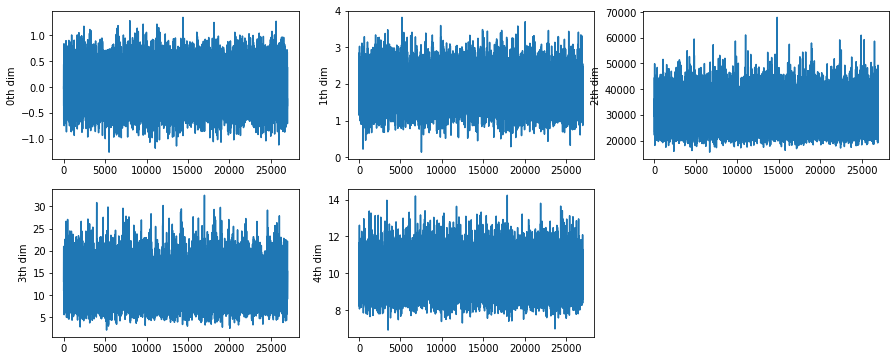

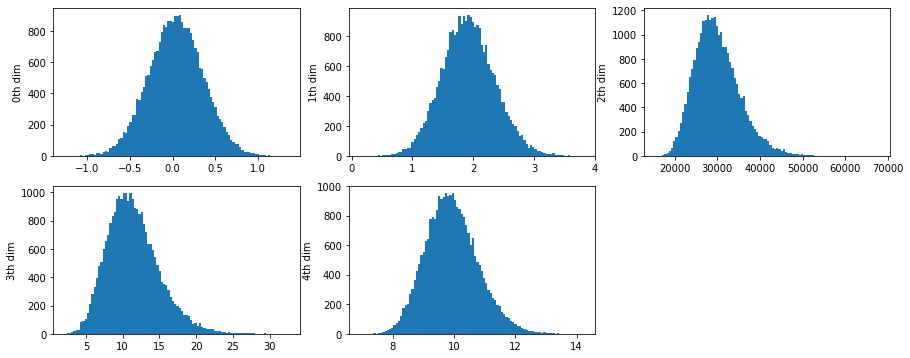

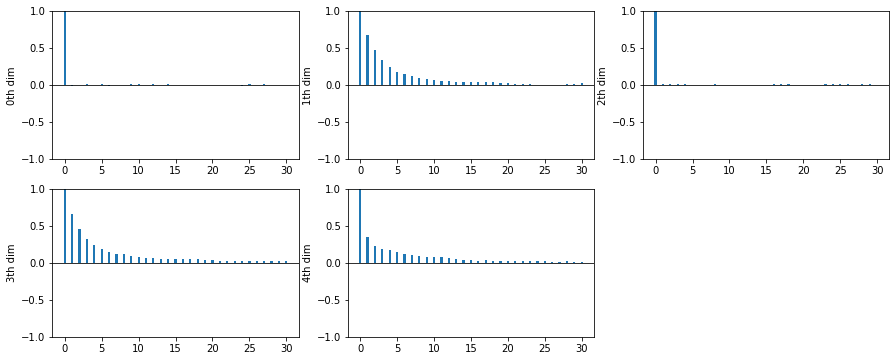

mean: : [0.03771087124517452, 1.9201499565561562, 30002.42867785878, 11.457538667342547, 9.931321302467362]
var   : [0.10014339175755464, 0.1883745189489544, 27989100.20775738, 12.615293292992401, 0.7309314550412653]
median: [[0.03853718429908835], [1.9097633607991467], [29412.87908840057], [11.073599331381217], [9.88147028857935]]
0.95ci: [[-0.5817835605717798, 0.6535802481446397], [1.0987314634599432, 2.799969675964648], [21320.521117349952, 41995.43071486659], [5.6772271052796555, 19.468586826175116], [8.395303120628984, 11.759349030373341]]


In [4]:
mc_samples_part1 = [sample[0:5] for sample in gibbs_p5_inst1.MC_sample]

gibbs_p5_diag_inst1_part1 = MCMC_Diag()
gibbs_p5_diag_inst1_part1.set_mc_samples_from_list(mc_samples_part1)
gibbs_p5_diag_inst1_part1.burnin(3000)
gibbs_p5_diag_inst1_part1.show_traceplot((3,2))
gibbs_p5_diag_inst1_part1.show_hist((3,2))
gibbs_p5_diag_inst1_part1.show_acf(30, (3,2))
print("mean: :", gibbs_p5_diag_inst1_part1.get_sample_mean())
print("var   :", gibbs_p5_diag_inst1_part1.get_sample_var())
print("median:", gibbs_p5_diag_inst1_part1.get_sample_quantile([0.5]))
print("0.95ci:", gibbs_p5_diag_inst1_part1.get_sample_quantile([0.025, 0.975]))

Every parameter seems to converge well, and ACF plots are good, too.
Again, the order is $\alpha, \beta, \tau_\alpha^2, \tau_\beta^2, \sigma^2$ for mean, variance, median, and 95% CI.

We may follow the standard(?) bayesian way to interpret these posterior samples. 
However, the interpretation is a little bit hard, cause these four (except for $\sigma^2$) are parameters of the higher hierarchy in the model.
I don't know whether a 'layman' can understand the hierarchy model or not. (sorry man:D)
Instead, let them wait for more two code blocks. 
Let's see $\alpha_i$ 's and $\beta_i$ 's first.

We can find that the values of $\tau_\alpha^2$ samples are very high.
But it will get understandable when we see the $\alpha_i, i=1,2,...,68$ values.

Next results are for $\alpha_1, \alpha_2, ..., \alpha_6$.
Despite $I=48$, they are too much to report here. Instead, I only report the first 6 patients.

'0th dim' to '5th dim' are correspond to $\alpha_1, \alpha_2, ..., \alpha_6$, respectively.

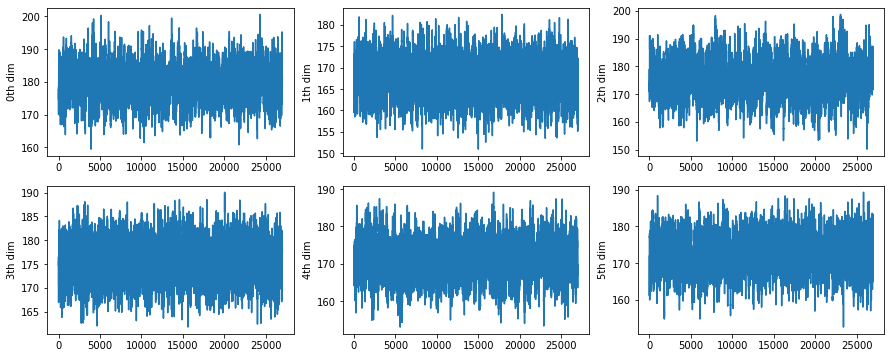

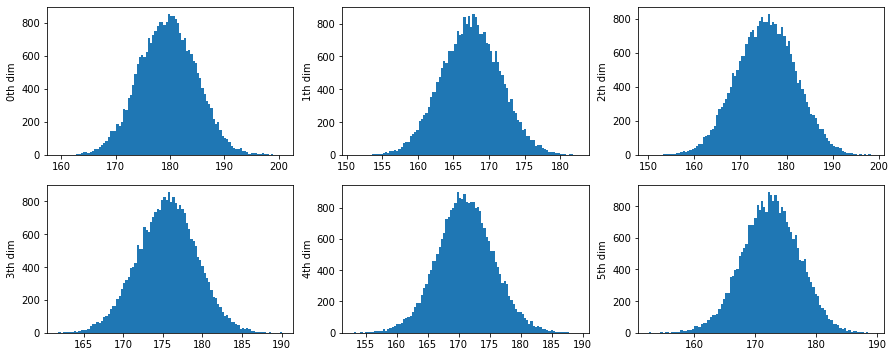

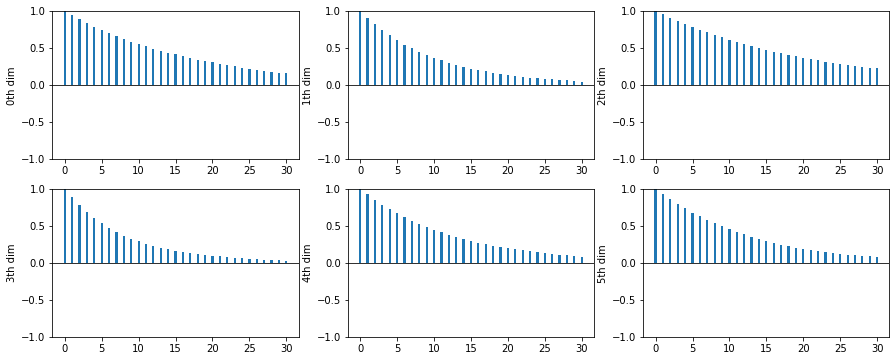

mean: : [179.5694920442396, 167.42221914476147, 175.53597671140395, 175.54261932540103, 171.07883611983465, 172.45691698877985]
var   : [27.746428485646657, 17.18698984618408, 41.402750423498, 14.041563101713201, 21.025340767432787, 21.791472385504363]
median: [[179.59733035482012], [167.44094154245687], [175.57427476312654], [175.6127943473993], [171.0275616231494], [172.4953350062579]]
0.95ci: [[169.25229381768108, 189.76692869115527], [159.32274014634064, 175.53191309268186], [162.91363412709828, 187.9547805403878], [168.08757387118337, 182.8308602149236], [161.99769150402776, 180.2785249842962], [163.05264491528345, 181.3823637092038]]


In [5]:
mc_samples_part2 = [sample[5][0:6] for sample in gibbs_p5_inst1.MC_sample]

gibbs_p5_diag_inst1_part2 = MCMC_Diag()
gibbs_p5_diag_inst1_part2.set_mc_samples_from_list(mc_samples_part2)
gibbs_p5_diag_inst1_part2.burnin(3000)
gibbs_p5_diag_inst1_part2.show_traceplot((3,2))
gibbs_p5_diag_inst1_part2.show_hist((3,2))
gibbs_p5_diag_inst1_part2.show_acf(30, (3,2))
print("mean: :", gibbs_p5_diag_inst1_part2.get_sample_mean())
print("var   :", gibbs_p5_diag_inst1_part2.get_sample_var())
print("median:", gibbs_p5_diag_inst1_part2.get_sample_quantile([0.5]))
print("0.95ci:", gibbs_p5_diag_inst1_part2.get_sample_quantile([0.025, 0.975]))

Here, even if autocorrelation decrease slowly, we can still say that the results look fine.
I could have done thinning to improve the ACF, but let me skip that.

On the model, each $\alpha_i$ means the intercept of weight axis for i-th pregnant woman.
In other words, even if i-th woman have visiting time 0, the woman can be believed to have the weight $\alpha_i$.

For example, 1st woman's weight are in $(169.25, 189.77)$ with probability 95%, when visiting time 0.
The intercept weight has mean $179.57$ and variance $27.75$.

I want to remark that all $\alpha_i$ s are related (dependent) to each other by the hierarchy in the model, through $\alpha$.
So, we can say that we could use all information of all women's weights and visiting times to construct each i-th woman's (intercept) weight (following Bayes' theorem.)
This is one of the bayesian hierarchical model's strengths.

Since $\alpha_i$ value is generally quite higher than its prior's mean $\alpha$ which has the normal prior with mean 0 and fixed variance,
the Bayes theorem give us very big $\tau_\alpha^2$ values (the variance of $\alpha_i$) to make consistency of this model fit.
This is the reason that $\tau_\alpha^2$ has so large values on the above part.

Finally, let's see the results for $\beta_1, \beta_2, ..., \beta_6$.
Again, the number of patients are too much to report here. I only report the first 6 patients.

Now, '0th dim' to '5th dim' are correspond to $\beta_1, \beta_2, ..., \beta_6$, respectively.

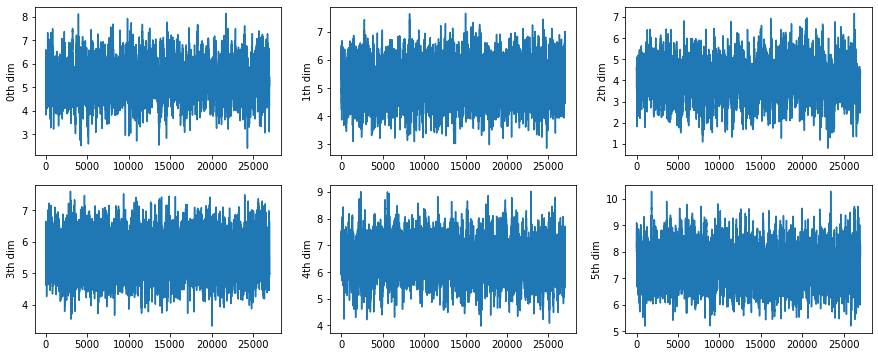

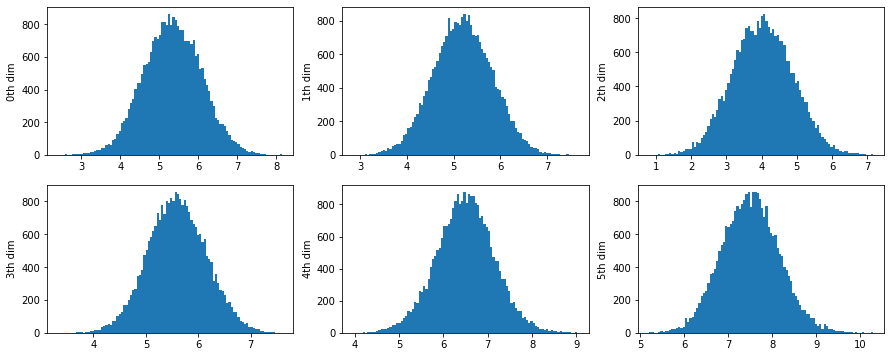

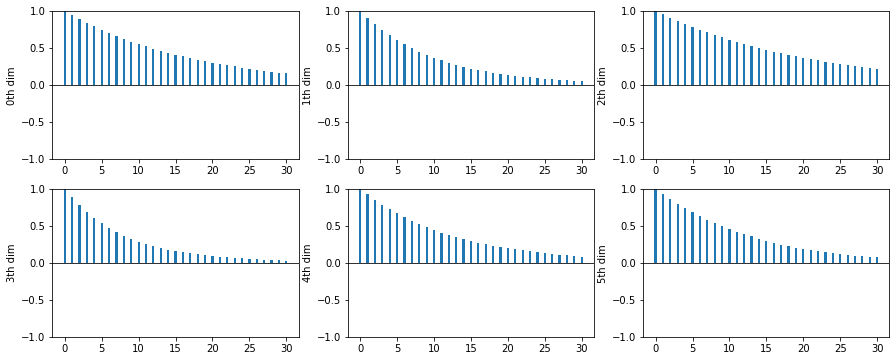

mean: : [5.338292113456255, 5.195789987004871, 4.024572281546148, 5.595952777253675, 6.491036628535139, 7.500851594864551]
var   : [0.5475396055917983, 0.39833739311345173, 0.7362836402046818, 0.3074997260138081, 0.4291487451829835, 0.4287806118014663]
median: [[5.337067545797831], [5.1948702218813105], [4.021257939441409], [5.587597251596976], [6.495060142472899], [7.495870349674934]]
0.95ci: [[3.9091563131363487, 6.778933328650976], [3.9693423756348913, 6.429189269968511], [2.377761993878141, 5.69724005300133], [4.522096371820387, 6.697728003103148], [5.180279083104551, 7.786943126944756], [6.257275010527484, 8.816336565827209]]


In [6]:
mc_samples_part3 = [sample[6][0:6] for sample in gibbs_p5_inst1.MC_sample]

gibbs_p5_diag_inst1_part3 = MCMC_Diag()
gibbs_p5_diag_inst1_part3.set_mc_samples_from_list(mc_samples_part3)
gibbs_p5_diag_inst1_part3.burnin(3000)
gibbs_p5_diag_inst1_part3.show_traceplot((3,2))
gibbs_p5_diag_inst1_part3.show_hist((3,2))
gibbs_p5_diag_inst1_part3.show_acf(30, (3,2))
print("mean: :", gibbs_p5_diag_inst1_part3.get_sample_mean())
print("var   :", gibbs_p5_diag_inst1_part3.get_sample_var())
print("median:", gibbs_p5_diag_inst1_part3.get_sample_quantile([0.5]))
print("0.95ci:", gibbs_p5_diag_inst1_part3.get_sample_quantile([0.025, 0.975]))

All traceplots and histograms seem fine. Autocorrelation values are slowly decreasing, but it's a level of speed that can be tolerated.

On our model, $\beta_i$ s are the i-th patient's slope between her visiting time and her weight.
The way to interpret this is, for example, if i-th patient's visiting time increase in one unit, the i-th patient's weight will increase in $\beta_i$ unit.
We can pick the mean value or median value (or mode value) as a point estimator (by using different loss function),
or use the credible interval as a set estimates.

As a more concrete example, by picking the mean values of $\alpha_1$, $\beta_1$, and $\sigma^2$, we can find that
$$y_1 = 179.57 + 5.34  t_1 + \epsilon$$
where $\epsilon \sim N(0, 9.93)$.
Using this expression, we can say that the first patients's weight will be 5.34 unit increased as her visiting time increases one unit (with a mean 0, variance 9.93 error).
In addition, if you want to consider the uncertainty of the $\beta_1$, you may say that $\beta_1$ is in the 95% credible interval $[3.91, 6.78]$ with probability 0.95.

This hierarchical model give us these kinds of information for 'every' i-th patient, which offers so strong as well as detailed inference results.
Moreover, like $\alpha_i$ s, $\beta_i$ s depend on each other by the hierarchy in the model, through $\beta$.
We can say that we could use all information of all women's weights and visiting times to construct each i-th woman's slope between her weight and her visiting time (following Bayes' theorem.)
